In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 12.0 MB/s eta 0:00:00


In [2]:
!pip install lightgbm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [4]:
virus_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                            'Age_Child', 
                                                                                            'Age_Adult',
                                                                                            'Age_Infant',
                                                                                            'Age_Elderly',
                                                                                            'Age_Mix',
                                                                                            'Health_Status', 
                                                                                            'Archaeal', 
                                                                                            'Bacteriophage', 
                                                                                            'Eukaryotic', 
                                                                                            'crassphage'], axis=1)


In [5]:
virus_df['Age'] = virus_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

In [6]:
virus_df.head()

,Age,Healthy,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,...,Papillomaviridae,Parvoviridae,Picornaviridae,Podoviridae,Polyomaviridae,Poxviridae,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae
0,0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
1,0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.14,0.0,0.0,0.0,0.00,0.0,0.0
3,0,1.0,0.0,0.0,0.0,3.84,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.84,0.0,0.0,0.0,3.84,0.0,0.0
4,0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0


In [7]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [8]:
def set_outliers_to_boundary(df):

    X = df.drop('Age', axis=1)

    isof = IsolationForest(random_state=42, contamination=0.05)
    isof.fit(X)

    outlier_preds = isof.predict(X)

    for i, pred in enumerate(outlier_preds):
        if pred == -1:
            upper_boundary = calculate_outliers(X.iloc[i])
            X.iloc[i] = X.iloc[i].clip(upper=upper_boundary[1])
    
    cleaned_df = pd.concat([X, df['Age']], axis=1)

    return cleaned_df

In [9]:
target = 'Healthy'

X = virus_df.loc[:,virus_df.columns!=target]
y = virus_df.loc[:,virus_df.columns==target]

In [10]:
oversample = SMOTENC(categorical_features=[0], random_state=42)
X, y = oversample.fit_resample(X, y)

In [11]:
X = set_outliers_to_boundary(X)

X does not have valid feature names, but IsolationForest was fitted with feature names


In [12]:
X.head()

,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,Circoviridae,Cruliviridae,...,Parvoviridae,Picornaviridae,Podoviridae,Polyomaviridae,Poxviridae,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae,Age
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0
1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.14,0.0,0.0,0.0,0.00,0.0,0.0,0
3,0.0,0.0,0.0,3.84,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.84,0.0,0.0,0.0,3.84,0.0,0.0,0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0


In [13]:
virus_ml_df = pd.concat([X, y], axis=1)

In [15]:
virus_ml_df.head()

,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,Circoviridae,Cruliviridae,...,Picornaviridae,Podoviridae,Polyomaviridae,Poxviridae,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae,Age,Healthy
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0,1.0
1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0,1.0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.14,0.0,0.0,0.0,0.00,0.0,0.0,0,1.0
3,0.0,0.0,0.0,3.84,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.84,0.0,0.0,0.0,3.84,0.0,0.0,0,1.0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0,1.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [17]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=True)

In [18]:
rf.fit(X_train, y_train.values.ravel())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_features='auto', n_estimators=200, n_jobs=-1,
                       random_state=42, warm_start=True)

In [19]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

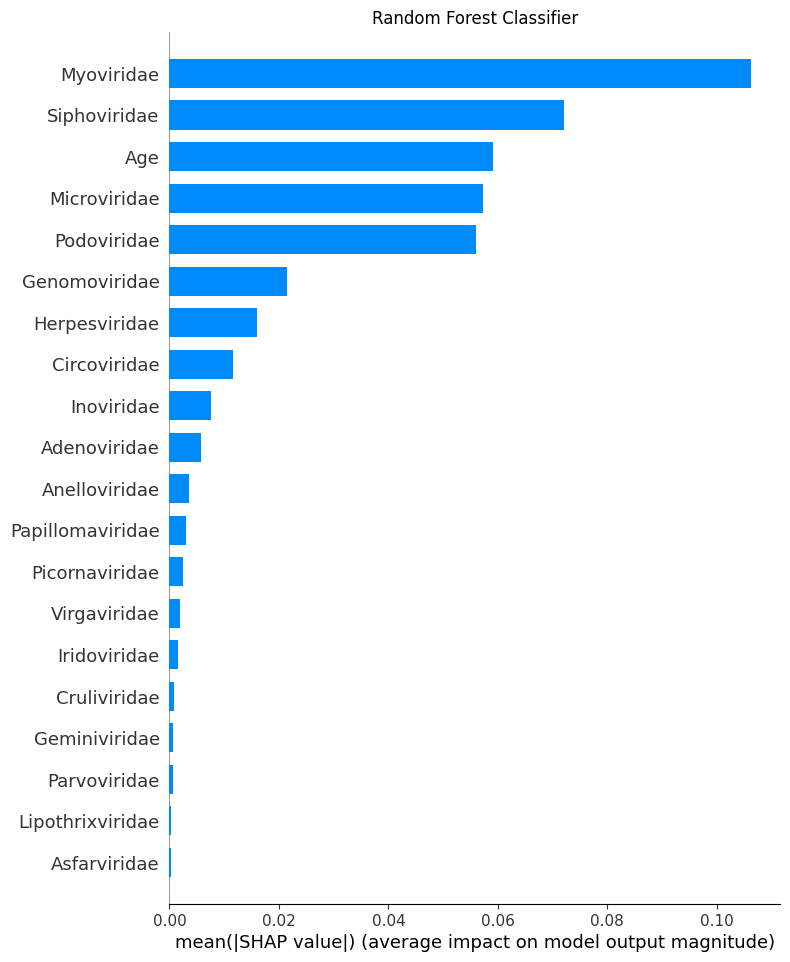

In [20]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("Random Forest Classifier")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


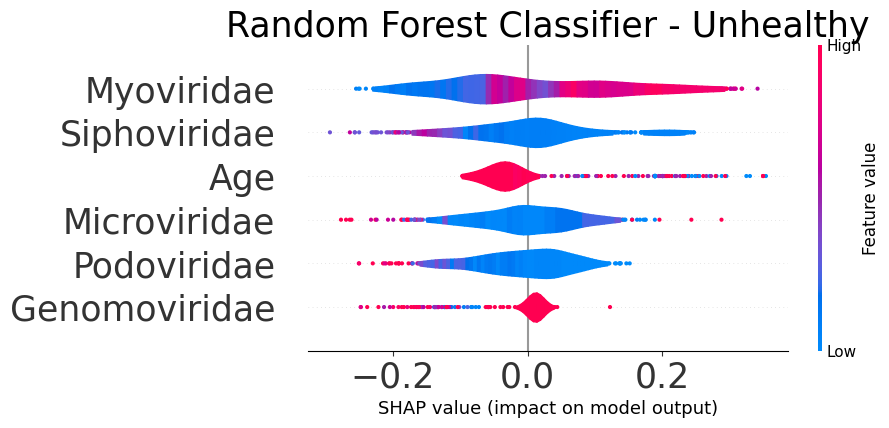

<Figure size 640x480 with 0 Axes>

In [21]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False, max_display=6)
plt.title("Random Forest Classifier - Unhealthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()
plt.savefig('/content/drive/MyDrive/ColabNotebooks/UMA/figures/rf-shap.png', dpi=700)

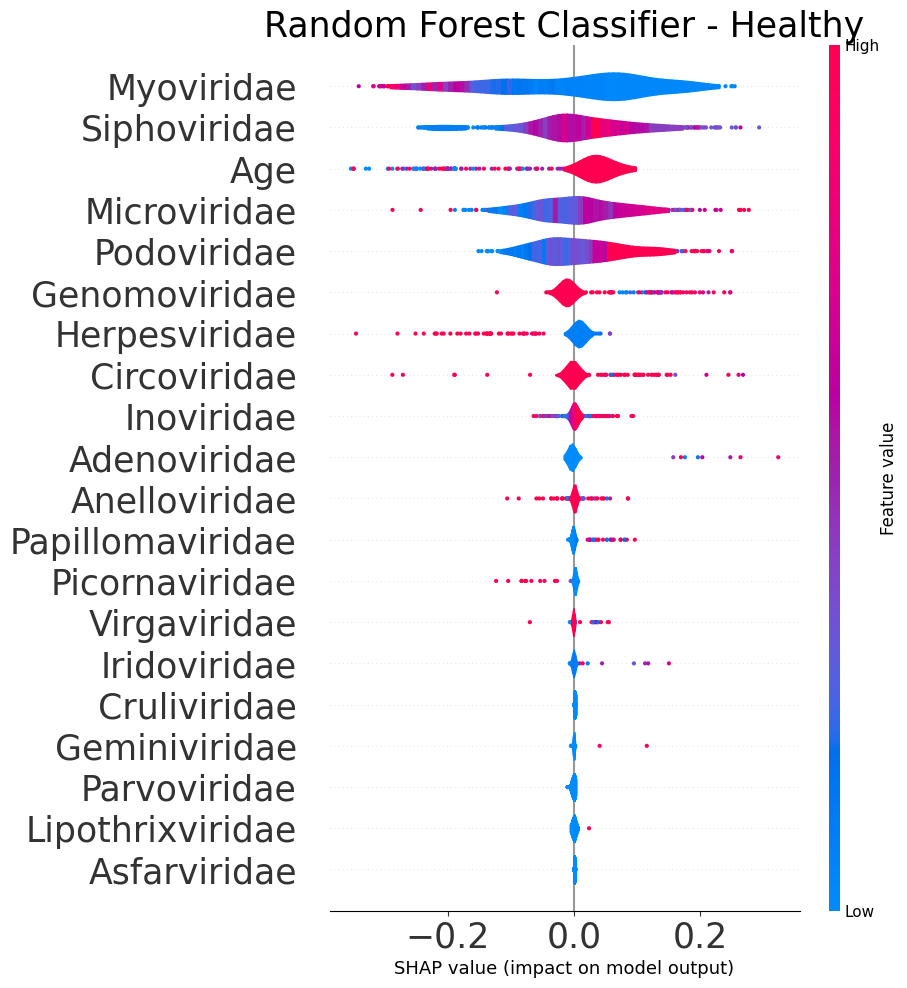

In [22]:
shap.summary_plot(shap_values[0], X_test, plot_type='violin', show=False)
plt.title("Random Forest Classifier - Healthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

<BarContainer object of 29 artists>

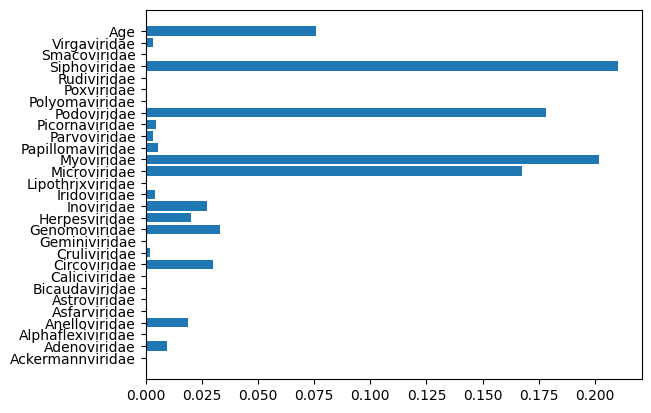

In [23]:
plt.barh(X.columns, rf.feature_importances_)

In [24]:
y_predicted = rf.predict(X_test)

In [25]:
y_pred_rf = y_predicted

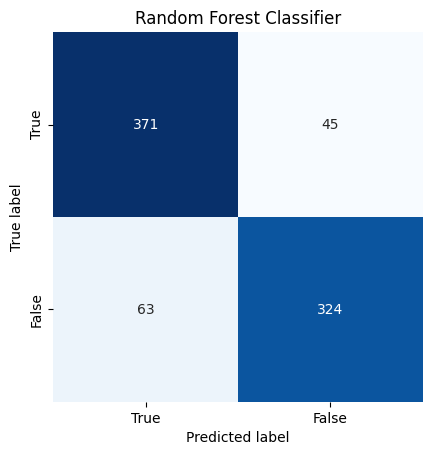

In [26]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Random Forest Classifier")
plt.show()

In [27]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

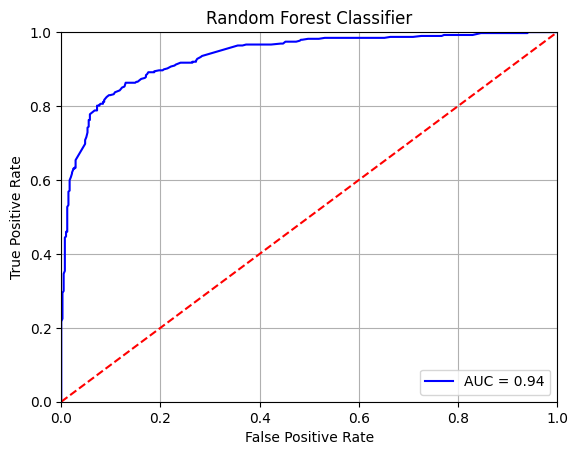

In [28]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Random Forest Classifier")
plt.show()

In [29]:
print('Random Forest')
# Display accuracy score
accuracy=accuracy_score(y_test, y_predicted)
# Display F1 score
f1=f1_score(y_test,y_predicted)
# Display recall
rcl = recall_score(y_test,y_predicted)
# Display precision
prcs = precision_score(y_test,y_predicted)

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')

Random Forest
Accuracy = 0.8655043586550436
F1 = 0.8571428571428572
Recall = 0.8372093023255814
Precision = 0.8780487804878049


extra tree

In [30]:
et = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                                  criterion='gini', max_depth=None, max_features='auto',
                                  max_leaf_nodes=None, max_samples=None,
                                  min_impurity_decrease=0.0,
                                  min_samples_leaf=1, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                                  oob_score=False, random_state=42, verbose=0,
                                  warm_start=True)

In [31]:
et.fit(X_train, y_train.values.ravel())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


ExtraTreesClassifier(max_features='auto', n_estimators=200, n_jobs=-1,
                     random_state=42, warm_start=True)

In [32]:
explainer = shap.TreeExplainer(et)
shap_values = explainer.shap_values(X_test)

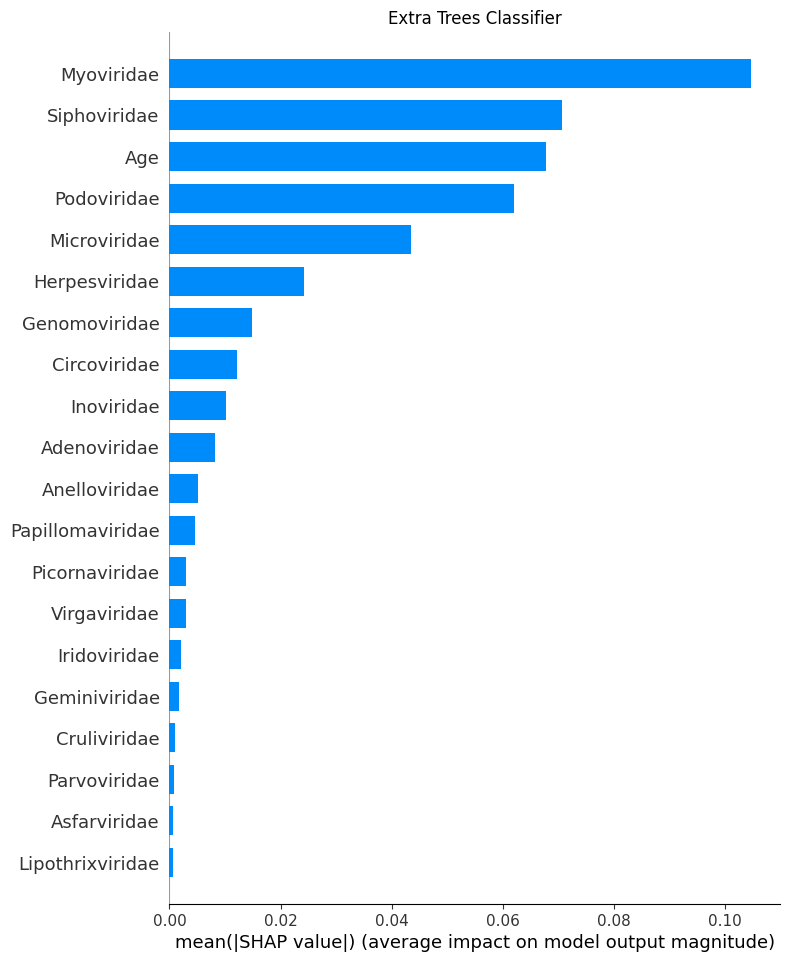

In [33]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("Extra Trees Classifier")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


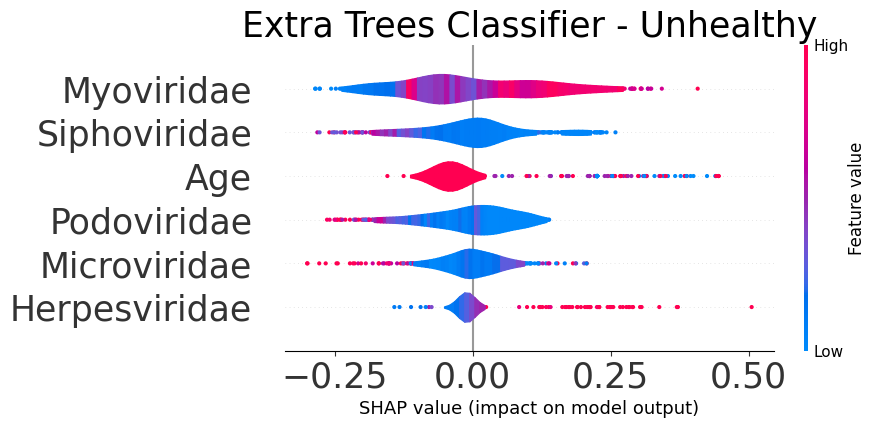

<Figure size 640x480 with 0 Axes>

In [34]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False, max_display=6)
plt.title("Extra Trees Classifier - Unhealthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()
plt.savefig('/content/drive/MyDrive/ColabNotebooks/UMA/figures/et-shap.png', dpi=700)

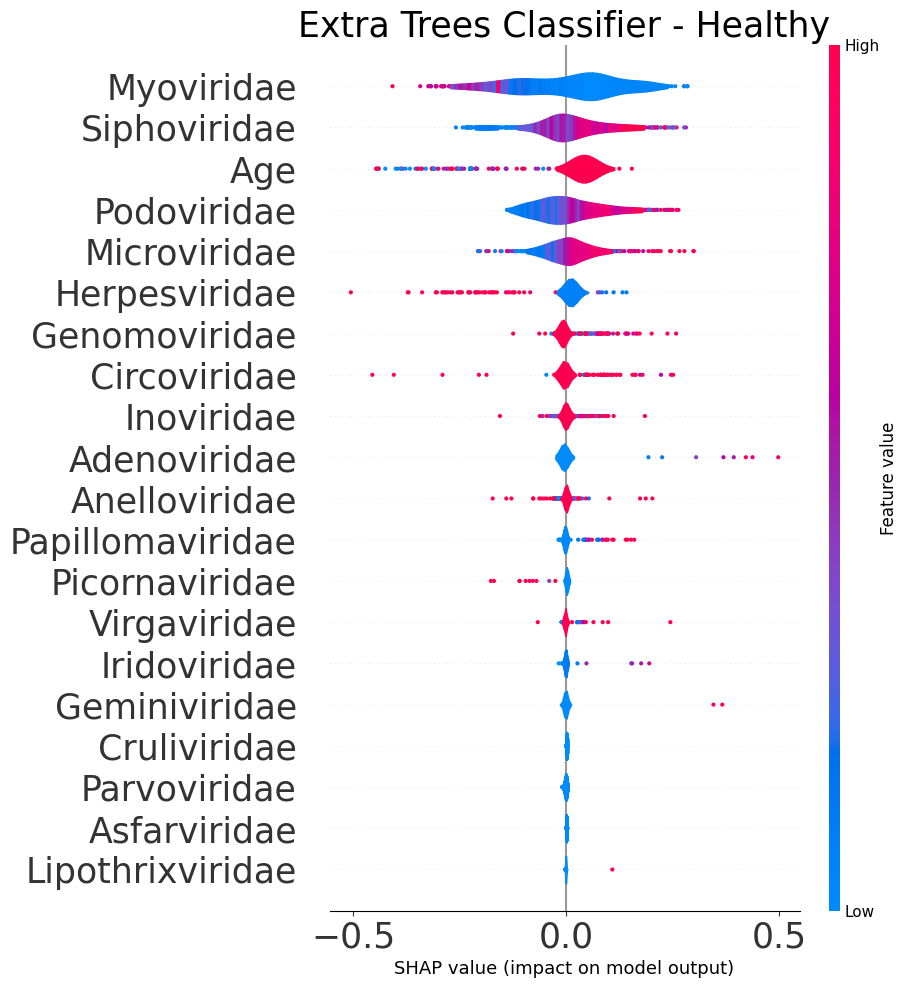

In [35]:
shap.summary_plot(shap_values[0], X_test, plot_type='violin', show=False)
plt.title("Extra Trees Classifier - Healthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

<BarContainer object of 29 artists>

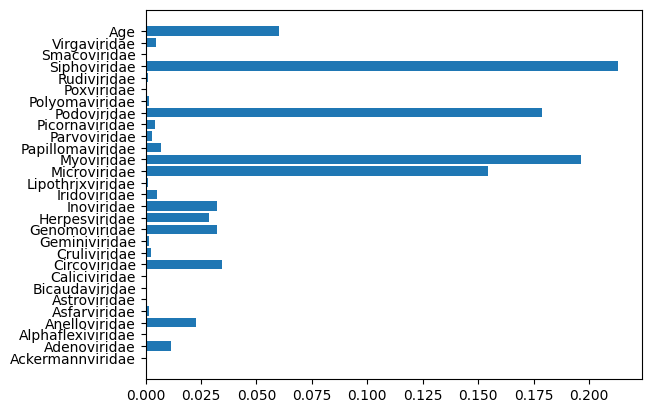

In [36]:
plt.barh(X.columns, et.feature_importances_)

In [37]:
y_predicted = et.predict(X_test)

In [38]:
y_pred_et = y_predicted

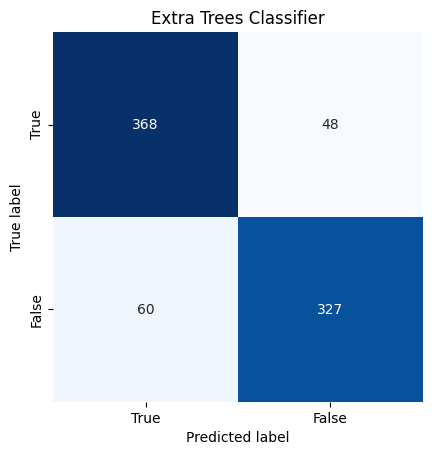

In [39]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Extra Trees Classifier")
plt.show()

In [40]:
probs = et.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

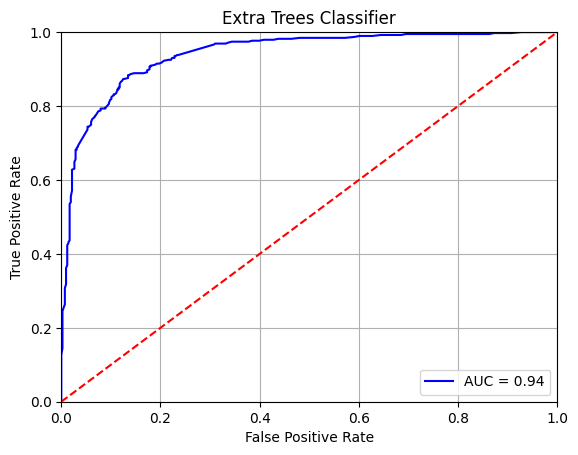

In [41]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Extra Trees Classifier")
plt.show()

In [42]:
print('Extra tree')
# Display accuracy score
accuracy=accuracy_score(y_test, y_predicted)
# Display F1 score
f1=f1_score(y_test,y_predicted)
# Display recall
rcl = recall_score(y_test,y_predicted)
# Display precision
prcs = precision_score(y_test,y_predicted)

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')

Extra tree
Accuracy = 0.8655043586550436
F1 = 0.858267716535433
Recall = 0.8449612403100775
Precision = 0.872


lightgbm 

In [43]:
lightgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                              importance_type='split', learning_rate=0.1, max_depth=-1,
                              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
                              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
lightgbm.fit(X_train, y_train.values.ravel())

LGBMClassifier(n_estimators=200, random_state=42)

In [45]:
explainer = shap.TreeExplainer(lightgbm)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


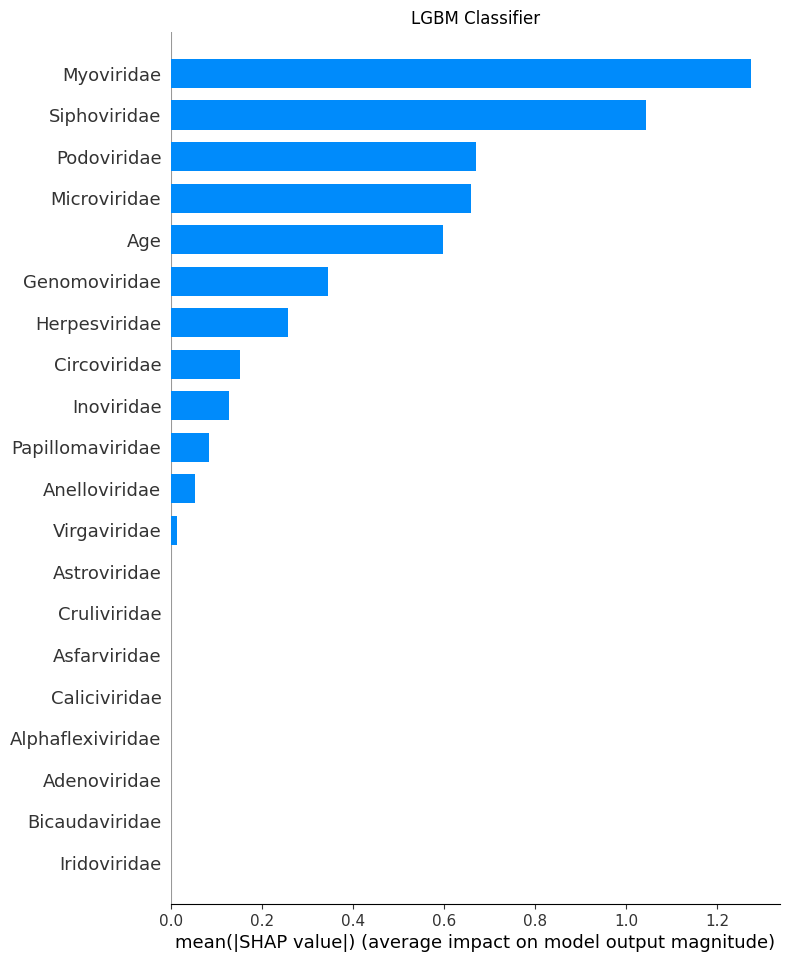

In [46]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("LGBM Classifier")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


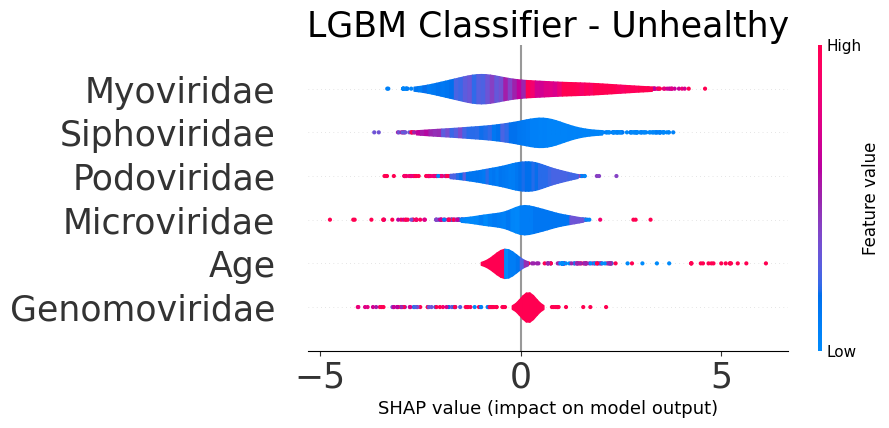

<Figure size 640x480 with 0 Axes>

In [47]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False, max_display=6)
plt.title("LGBM Classifier - Unhealthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()
plt.savefig('/content/drive/MyDrive/ColabNotebooks/UMA/figures/lgbm-shap.png', dpi=700)

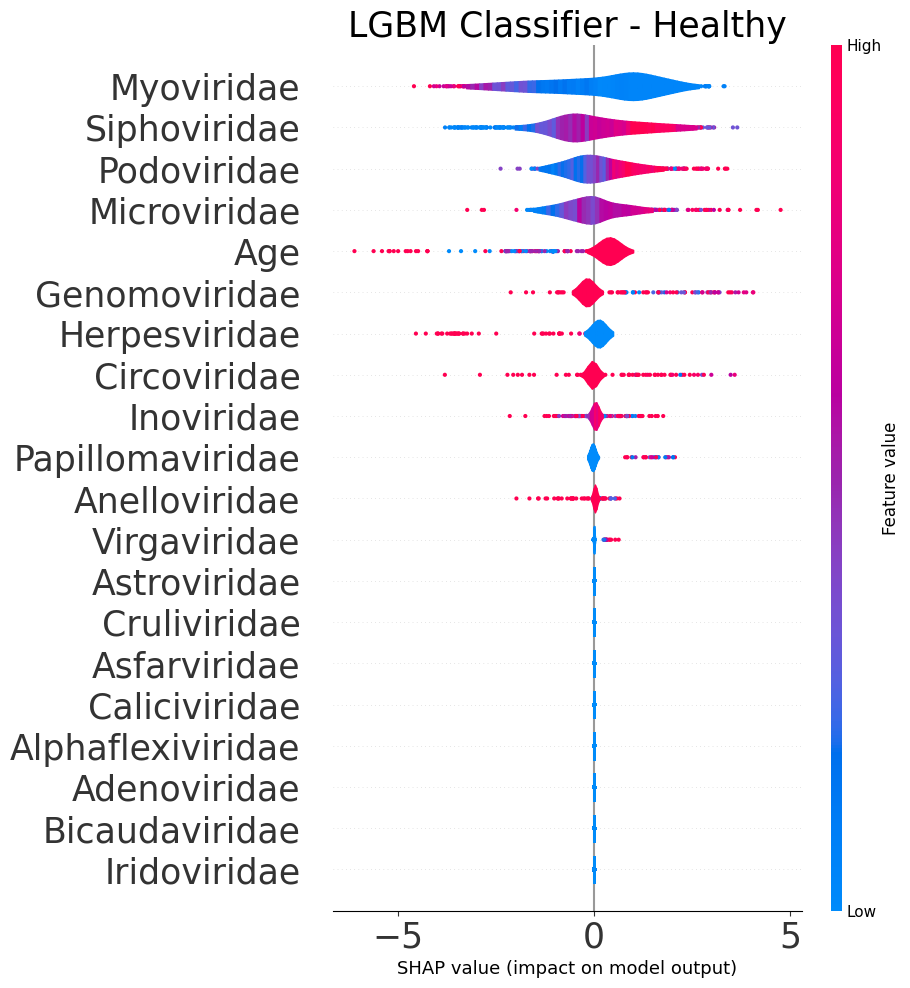

In [48]:
shap.summary_plot(shap_values[0], X_test, plot_type='violin', show=False)
plt.title("LGBM Classifier - Healthy", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

<BarContainer object of 29 artists>

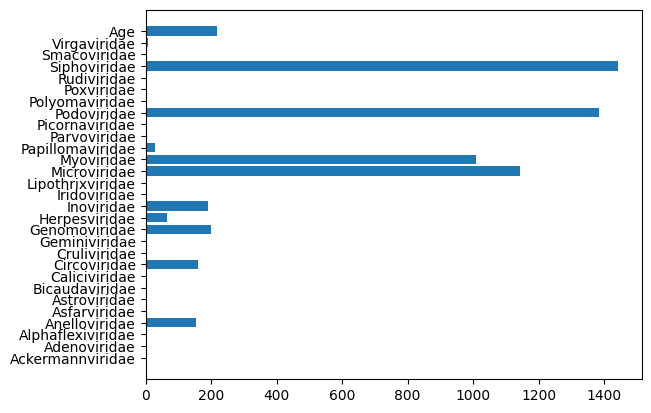

In [49]:
plt.barh(X.columns, lightgbm.feature_importances_)

In [50]:
y_predicted = lightgbm.predict(X_test)

In [51]:
y_pred_lgbm = y_predicted

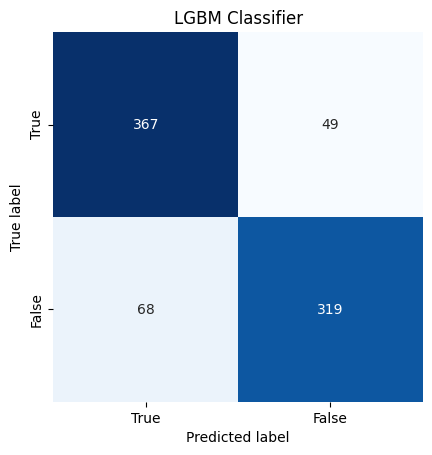

In [52]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("LGBM Classifier")
plt.show()

In [53]:
probs = lightgbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

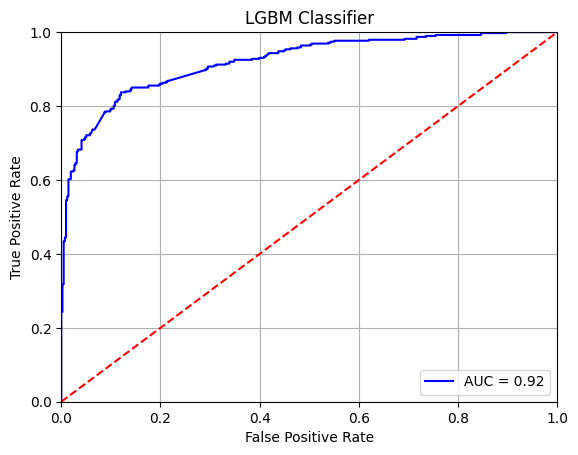

In [54]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("LGBM Classifier")
plt.show()

In [55]:
print('LGBM')
# Display accuracy score
accuracy=accuracy_score(y_test, y_predicted)
# Display F1 score
f1=f1_score(y_test,y_predicted)
# Display recall
rcl = recall_score(y_test,y_predicted)
# Display precision
prcs = precision_score(y_test,y_predicted)

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')

LGBM
Accuracy = 0.8542963885429639
F1 = 0.8450331125827815
Recall = 0.8242894056847545
Precision = 0.8668478260869565


In [56]:
pred_df = pd.DataFrame()
pred_df['RF'] = y_pred_rf
pred_df['ET'] = y_pred_et
pred_df['LGBM'] = y_pred_lgbm

pred_df['target'] = pred_df.mode(axis=1)[0]
pred_df.head()

,RF,ET,LGBM,target
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,1.0


In [57]:
# Display accuracy score
accuracy=accuracy_score(y_test, pred_df['target'])
# Display F1 score
f1=f1_score(y_test, pred_df['target'])
# Display recall
rcl = recall_score(y_test, pred_df['target'])
# Display precision
prcs = precision_score(y_test, pred_df['target'])

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')
print(f"Confusion matrix \n{confusion_matrix(y_test, pred_df['target'])}")

Accuracy = 0.8729763387297634
F1 = 0.8647214854111406
Recall = 0.8423772609819121
Precision = 0.888283378746594
Confusion matrix 
[[375  41]
 [ 61 326]]
